# Loading the dataset

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/sample_data/weatherAUS.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Data Preprocessing

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import pandas as pd

# Load the dataset
file_path = '/content/sample_data/weatherAUS.csv'
data = pd.read_csv(file_path)

# Drop rows where 'RainTomorrow' is NaN
data_cleaned = data.dropna(subset=['RainTomorrow'])

# Now, separate features and target variable again
X = data_cleaned.drop('RainTomorrow', axis=1)
y = data_cleaned['RainTomorrow'].map({'Yes': 1, 'No': 0})  # Ensure this conversion has no NaN values

# Identifying numerical and categorical columns (excluding 'Date' from categorical columns)
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns.drop(['Date'])

# Preprocessor for Bayesian Networks (Ordinal Encoding for Categorical, Median Imputation for Numerical)
bn_numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

bn_categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

bn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', bn_numerical_transformer, num_cols),
        ('cat', bn_categorical_transformer, cat_cols)
    ])

# Preprocessor for other classifiers (OneHot Encoding for Categorical, Median Imputation and Scaling for Numerical)
general_numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

general_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

general_preprocessor = ColumnTransformer(
    transformers=[
        ('num', general_numerical_transformer, num_cols),
        ('cat', general_categorical_transformer, cat_cols)
    ])

# Apply the preprocessing for Bayesian Networks
X_bn_preprocessed = bn_preprocessor.fit_transform(X)

# Apply the preprocessing for other classifiers
X_general_preprocessed = general_preprocessor.fit_transform(X)

# Split the preprocessed data into training and testing sets for general classifiers
X_train, X_test, y_train, y_test = train_test_split(X_general_preprocessed, y, test_size=0.2, random_state=0)

print("Bayesian Network Preprocessed Shape:", X_bn_preprocessed.shape)
print("General Classifier Preprocessed Shape:", X_train.shape, X_test.shape)


Bayesian Network Preprocessed Shape: (142193, 21)
General Classifier Preprocessed Shape: (113754, 115) (28439, 115)


In [ ]:
def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Calculating metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }

    return metrics

# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     22067
           1       0.74      0.51      0.61      6372

    accuracy                           0.85     28439
   macro avg       0.80      0.73      0.76     28439
weighted avg       0.84      0.85      0.84     28439



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize the GridSearchCV object
grid_search_lr = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit it to the training data
grid_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)


Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.847460315764408


In [ ]:
baseline_log_reg = LogisticRegression(max_iter=1000)
baseline_log_reg.fit(X_train, y_train)
baseline_metrics = evaluate_model(baseline_log_reg, X_test, y_test)

print("Baseline Logistic Regression metrics:", baseline_metrics)


Baseline Logistic Regression metrics: {'accuracy': 0.8497134217096242, 'precision': 0.7354129263913824, 'recall': 0.5142812303829253, 'f1': 0.6052826006649428}


In [ ]:
# Best model from Grid Search
tuned_log_reg = grid_search_lr.best_estimator_

# Evaluate the tuned model
tuned_metrics = evaluate_model(tuned_log_reg, X_test, y_test)

print("Tuned Logistic Regression metrics:", tuned_metrics)


Tuned Logistic Regression metrics: {'accuracy': 0.8497134217096242, 'precision': 0.7354129263913824, 'recall': 0.5142812303829253, 'f1': 0.6052826006649428}


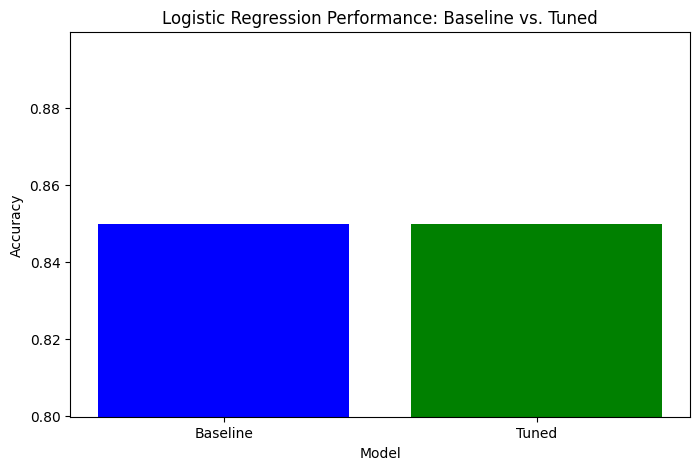

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['Baseline', 'Tuned']
accuracies = [baseline_metrics['accuracy'], tuned_metrics['accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Performance: Baseline vs. Tuned')
plt.ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
plt.show()


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train the Naïve Bayes model
nb = GaussianNB()
nb.fit(X_train.toarray(), y_train)  # Convert to array if using sparse matrix

# Predictions
y_pred_nb = nb.predict(X_test.toarray())

# Evaluation
print("Naïve Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


Naïve Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.64      0.75     22067
           1       0.37      0.72      0.49      6372

    accuracy                           0.66     28439
   macro avg       0.63      0.68      0.62     28439
weighted avg       0.77      0.66      0.69     28439



Baseline Naive Bayes metrics: {'accuracy': 0.6601849572769788, 'precision': 0.368509346540981, 'recall': 0.7239485247959824, 'f1': 0.4884065643197459}
Best parameters for Naive Bayes: {'var_smoothing': 1.0}
Best score for Naive Bayes: 0.8244984817476928
Tuned Naive Bayes metrics: {'accuracy': 0.8280881887548789, 'precision': 0.6802820325796256, 'recall': 0.43910860012554925, 'f1': 0.5337148307105388}


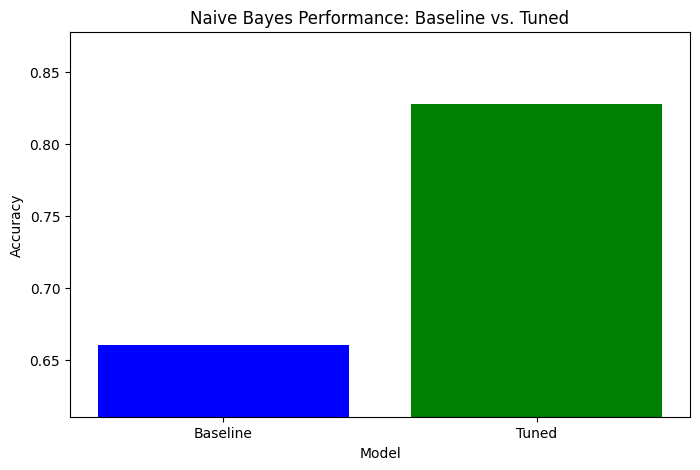

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }
    return metrics

# Baseline Naive Bayes model evaluation
baseline_nb = GaussianNB()
baseline_nb.fit(X_train.toarray(), y_train)  # Ensure X_train is converted to dense
baseline_metrics_nb = evaluate_model(baseline_nb, X_test.toarray(), y_test)  # Ensure X_test is converted to dense

print("Baseline Naive Bayes metrics:", baseline_metrics_nb)

# Hyperparameter tuning for Naive Bayes
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train.toarray(), y_train)  # Convert X_train to dense

print("Best parameters for Naive Bayes:", grid_search_nb.best_params_)
print("Best score for Naive Bayes:", grid_search_nb.best_score_)

# Evaluate the tuned Naive Bayes model
tuned_nb = grid_search_nb.best_estimator_
tuned_metrics_nb = evaluate_model(tuned_nb, X_test.toarray(), y_test)  # Convert X_test to dense

print("Tuned Naive Bayes metrics:", tuned_metrics_nb)

# Visualization
models_nb = ['Baseline', 'Tuned']
accuracies_nb = [baseline_metrics_nb['accuracy'], tuned_metrics_nb['accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models_nb, accuracies_nb, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Performance: Baseline vs. Tuned')
plt.ylim([min(accuracies_nb) - 0.05, max(accuracies_nb) + 0.05])
plt.show()


# Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the decision tree model
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)

# Evaluation
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87     22067
           1       0.54      0.55      0.55      6372

    accuracy                           0.79     28439
   macro avg       0.70      0.71      0.71     28439
weighted avg       0.80      0.79      0.80     28439



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Evaluate the baseline model
baseline_dt = DecisionTreeClassifier(random_state=0)
baseline_dt.fit(X_train, y_train)  # No need to convert to dense array for decision trees
baseline_metrics_dt = evaluate_model(baseline_dt, X_test, y_test)

print("Baseline Decision Tree metrics:", baseline_metrics_dt)


Baseline Decision Tree metrics: {'accuracy': 0.7942614015963994, 'precision': 0.5399846508058327, 'recall': 0.5521029504080351, 'f1': 0.5459765655311554}


In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best score for Decision Tree:", grid_search_dt.best_score_)
# Evaluate the tuned model
tuned_dt = grid_search_dt.best_estimator_
tuned_metrics_dt = evaluate_model(tuned_dt, X_test, y_test)

print("Tuned Decision Tree metrics:", tuned_metrics_dt)


Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}
Best score for Decision Tree: 0.8374475134289472
Tuned Decision Tree metrics: {'accuracy': 0.8412391434297971, 'precision': 0.7141868512110726, 'recall': 0.4858757062146893, 'f1': 0.5783132530120482}


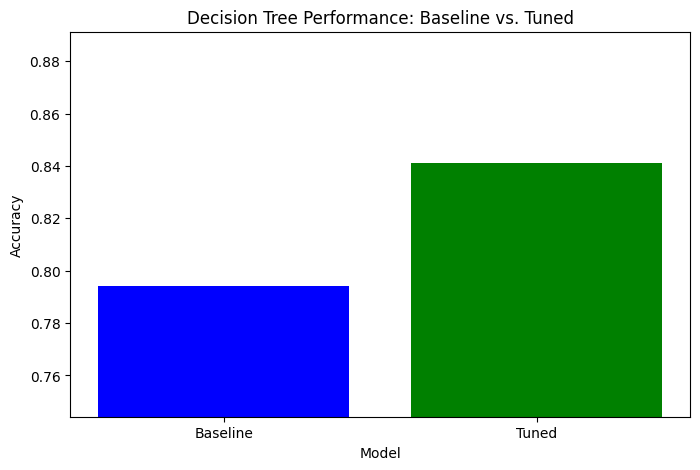

In [ ]:
# Visualization
models_dt = ['Baseline', 'Tuned']
accuracies_dt = [baseline_metrics_dt['accuracy'], tuned_metrics_dt['accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models_dt, accuracies_dt, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Decision Tree Performance: Baseline vs. Tuned')
plt.ylim([min(accuracies_dt) - 0.05, max(accuracies_dt) + 0.05])
plt.show()


# Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize and train the neural network model
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test)

# Evaluation
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_mlp))


Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     22067
           1       0.69      0.59      0.64      6372

    accuracy                           0.85     28439
   macro avg       0.79      0.76      0.77     28439
weighted avg       0.84      0.85      0.85     28439



In [ ]:
from sklearn.neural_network import MLPClassifier

# Evaluate the baseline model
baseline_nn = MLPClassifier(random_state=1, max_iter=300)
baseline_nn.fit(X_train, y_train)
baseline_metrics_nn = evaluate_model(baseline_nn, X_test, y_test)

print("Baseline Neural Network metrics:", baseline_metrics_nn)


Baseline Neural Network metrics: {'accuracy': 0.8502760293962516, 'precision': 0.6941587068332109, 'recall': 0.5930634023854363, 'f1': 0.6396411645226812}


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Simplified hyperparameter grid
param_dist_nn = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
}

# Randomized search
random_search_nn = RandomizedSearchCV(MLPClassifier(random_state=1, max_iter=100), param_distributions=param_dist_nn, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=1)
random_search_nn.fit(X_train, y_train)

print("Best parameters for Neural Network:", random_search_nn.best_params_)
print("Best score for Neural Network:", random_search_nn.best_score_)


Best parameters for Neural Network: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'activation': 'tanh'}
Best score for Neural Network: 0.8511173233468714


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Get the best estimator from the randomized search
tuned_nn = random_search_nn.best_estimator_

# Evaluate the tuned model
tuned_metrics_nn = evaluate_model(tuned_nn, X_test, y_test)
print("Tuned Neural Network Accuracy:", tuned_metrics_nn['accuracy'])


Tuned Neural Network Accuracy: 0.8615633461092163


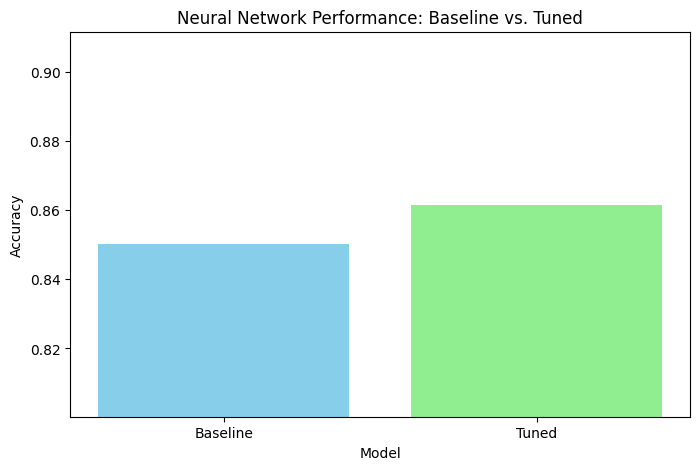

In [ ]:
# Visualization
models_nn = ['Baseline', 'Tuned']
accuracies_nn = [baseline_metrics_nn['accuracy'], tuned_metrics_nn['accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models_nn, accuracies_nn, color=['skyblue', 'lightgreen'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Neural Network Performance: Baseline vs. Tuned')
plt.ylim([min(accuracies_nn) - 0.05, max(accuracies_nn) + 0.05])
plt.show()


# Bayesian Network

In [ ]:
!pip install pgmpy


In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# Define a simple Bayesian Network structure using the updated class name
model = BayesianNetwork([('Rainfall', 'RainTomorrow'), ('Humidity3pm', 'RainTomorrow')])

# Proceed with parameter estimation as before
data_cleaned = data.dropna(subset=['Rainfall', 'Humidity3pm', 'RainTomorrow'])
data_cleaned = data_cleaned[['Rainfall', 'Humidity3pm', 'RainTomorrow']].sample(n=5000, random_state=1)

# Fit the model
model.fit(data_cleaned, estimator=BayesianEstimator, prior_type="BDeu")

# Inference
infer = VariableElimination(model)
q = infer.query(variables=['RainTomorrow'], evidence={'Rainfall': 1, 'Humidity3pm': 50})
print(q)


+-------------------+---------------------+
| RainTomorrow      |   phi(RainTomorrow) |
+===================+=====================+
| RainTomorrow(No)  |              0.9999 |
+-------------------+---------------------+
| RainTomorrow(Yes) |              0.0001 |
+-------------------+---------------------+
